In [13]:
import pandas as pd
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.util import Surv
from sklearn.model_selection import train_test_split, cross_val_score
from sksurv.metrics import concordance_index_censored

from sksurv.ensemble import RandomSurvivalForest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from numpy import corrcoef
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from itertools import product


In [ ]:
famine = pd.read_csv("../processed data/famine_survival.csv")
famine['event_observed'] = True

# survival array for dependent 
# Select relevant features
features = [
  "avg_nino34", "avg_temp_summer", "avg_temp_winter", "avg_precip_winter",
   "avg_PDSI","avg_Deaths",
   "avg_ongoing_wars"

]

X = famine[features]
#standardize features
X = (X - X.mean()) / X.std()
y = Surv.from_dataframe("event_observed", "duration", famine.loc[X.index])

# Train/test split 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Nested CV

In [34]:
# ============ Shared Setup ============ #
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

def concordance_scorer(estimator, X, y):
    pred = estimator.predict(X)
    return concordance_index_censored(y["event_observed"], y["duration"], pred)[0]

# ============ RSF ============ #
rsf_param_grid = {
    "n_estimators": [10, 20, 50],
    "min_samples_split": [5, 10, 15],
    "min_samples_leaf": [5, 10, 15],
    "max_features": ["sqrt", 0.5]
}

rsf = RandomSurvivalForest(random_state=42, n_jobs=-1)
gs_rsf = GridSearchCV(rsf, rsf_param_grid, scoring=concordance_scorer, cv=inner_cv, n_jobs=-1, verbose=1)
#gs_rsf.fit(X, y)
#best_rsf = gs_rsf.best_estimator_
rsf_cv_scores = cross_val_score(gs_rsf, X, y, cv=outer_cv, scoring=concordance_scorer)
rsf_cindex_mean = rsf_cv_scores.mean()
rsf_cindex_std = rsf_cv_scores.std()
perm_rsf = permutation_importance(gs_rsf.fit(X,y).best_estimator_, X, y, n_repeats=50, random_state=42, scoring=concordance_scorer)

# ============ GBSA ============ #
gbsa_param_grid = {
    "n_estimators": [10, 20, 30],
    "learning_rate": [0.1, 0.5, 0.9],
    "max_depth": [1, 3, 5]
}

gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
gs_gbsa = GridSearchCV(gbsa, gbsa_param_grid, scoring=concordance_scorer, cv=inner_cv, n_jobs=-1, verbose=1)
#gs_gbsa.fit(X, y)
#best_gbsa = gs_gbsa.best_estimator_
gbsa_cv_scores = cross_val_score(gs_gbsa, X, y, cv=outer_cv, scoring=concordance_scorer)
gbsa_cindex_mean = gbsa_cv_scores.mean()
gbsa_cindex_std = gbsa_cv_scores.std()
perm_gbsa = permutation_importance(gs_gbsa.fit(X,y).best_estimator_, X, y, n_repeats=50, random_state=42, scoring=concordance_scorer)

# ============ Regular Cox PH ============ #
coxph = CoxPHSurvivalAnalysis()
coxph_cv_scores = cross_val_score(coxph, X, y, cv=outer_cv, scoring=concordance_scorer)
coxph.fit(X, y)
coxph_cindex_mean = coxph_cv_scores.mean()
coxph_cindex_std = coxph_cv_scores.std()
perm_coxph = permutation_importance(coxph, X, y, n_repeats=50, random_state=42, scoring=concordance_scorer)

# ============ Lasso Cox PH ============ #
cox_lasso_param_grid = {
    "alphas": [[0.001], [0.01], [0.1], [1], [10], [100]],
    "l1_ratio": [0.01, 0.5, 1.0]  # 0.0 for Ridge, 1.0 for Lasso
}

cox_lasso = CoxnetSurvivalAnalysis(max_iter=10000)
gs_lasso = GridSearchCV(cox_lasso, cox_lasso_param_grid, scoring=concordance_scorer, cv=inner_cv, n_jobs=-1, verbose=1)
#gs_lasso.fit(X, y)
#best_lasso = gs_lasso.best_estimator_
lasso_cv_scores = cross_val_score(gs_lasso, X, y, cv=outer_cv, scoring=concordance_scorer)
lasso_cindex_mean = lasso_cv_scores.mean()
lasso_cindex_std = lasso_cv_scores.std()
perm_lasso = permutation_importance(gs_lasso.fit(X,y).best_estimator_, X, y, n_repeats=50, random_state=42, scoring=concordance_scorer)

# ============ Print Results ============ #
print("\n=== Best Hyperparameters ===")
print("RSF:", gs_rsf.best_params_)
print("GBSA:", gs_gbsa.best_params_)
print("Lasso Cox:", gs_lasso.best_params_)

print("\n=== Concordance Index (C-index) ===")
print(f"RSF:         {rsf_cindex_mean:.4f} ± {rsf_cindex_std:.4f}")
print(f"GBSA:        {gbsa_cindex_mean:.4f} ± {gbsa_cindex_std:.4f}")
print(f"Cox PH:      {coxph_cindex_mean:.4f} ± {coxph_cindex_std:.4f}")
print(f"Lasso Cox:   {lasso_cindex_mean:.4f} ± {lasso_cindex_std:.4f}")


Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 2

c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\sklearn\model_selection\_search.py:1089: UserWarning: all coefficients are zero, consider decreasing alpha.
  self.best_estimator_.fit(X, y, **routed_params.estimator.fit)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits

=== Best Hyperparameters ===
RSF: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 50}
GBSA: {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 20}
Lasso Cox: {'alphas': [0.01], 'l1_ratio': 0.5}

=== Concordance Index (C-index) ===
RSF:         0.5969 ± 0.0967
GBSA:        0.6087 ± 0.0862
Cox PH:      0.5340 ± 0.1214
Lasso Cox:   0.4961 ± 0.1128


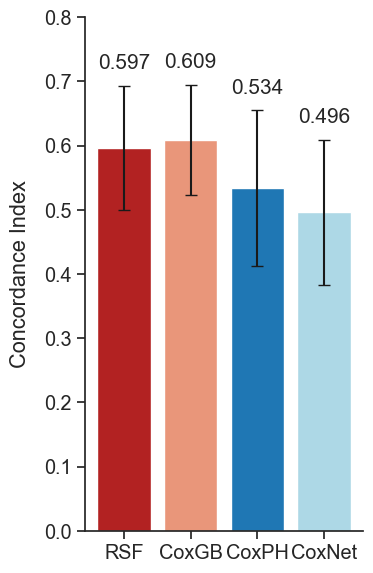

In [ ]:
sns.set(style="ticks", font_scale=1.3)

plt.figure(figsize=(4, 6))
methods = ["RSF", "CoxGB", "CoxPH", "CoxNet"]
means = [rsf_cindex_mean, gbsa_cindex_mean, coxph_cindex_mean, lasso_cindex_mean]
errors = [rsf_cindex_std, gbsa_cindex_std, coxph_cindex_std, lasso_cindex_std]
colors = ["firebrick", "darksalmon", "tab:blue", "lightblue"]

bars = plt.bar(
    methods, means, yerr=errors, capsize=4,
    color=colors, edgecolor=None
)

# Add values above the error bars
for bar, mean, err in zip(bars, means, errors):
    top = mean + err
    plt.text(
        bar.get_x() + bar.get_width() / 2, top + 0.02,  # position slightly above error bar
        f"{mean:.3f}", ha='center', va='bottom', fontsize=15
    )
    
plt.ylabel("Concordance Index", labelpad=10)
plt.xticks(rotation=0)
plt.ylim(0, 0.8)  # Adjust based on your data
plt.tight_layout()
sns.despine()
plt.savefig("../figures/plots/ML_CI_nestedCV.pdf", dpi=300)
plt.show()

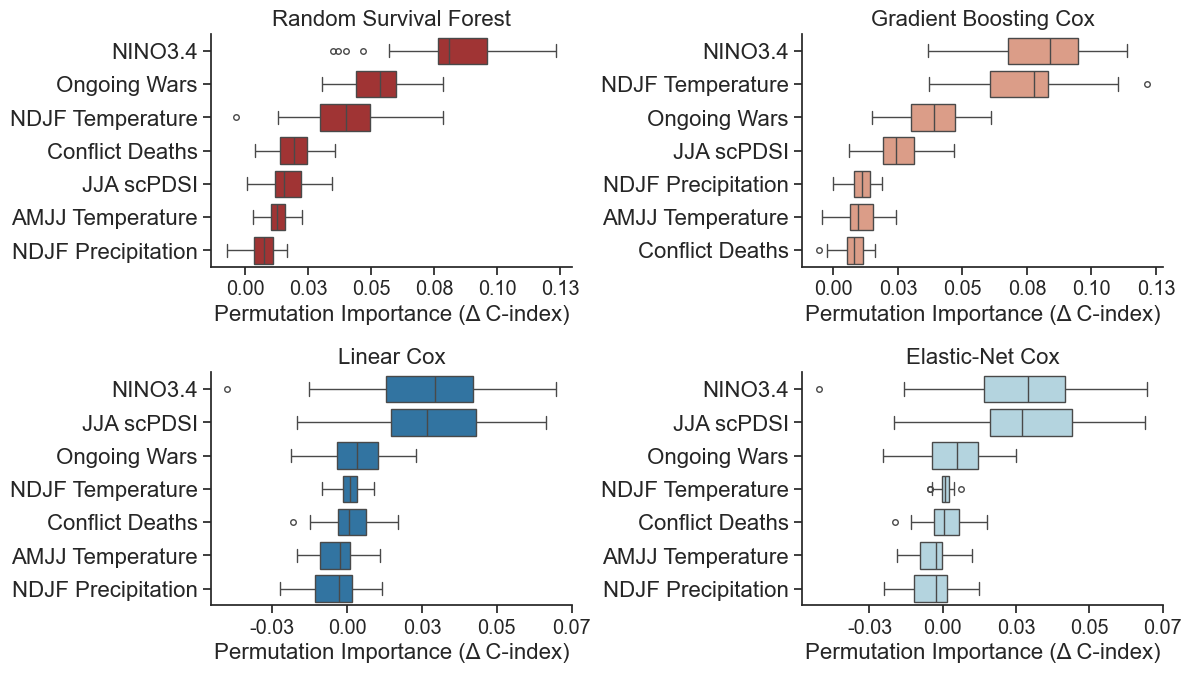

In [ ]:
sns.set(style="ticks", font_scale=1.3)

cols_to_plot = {
    "avg_nino34": "NINO3.4",
    "avg_PDSI": "JJA scPDSI",
    "avg_ongoing_wars": "Ongoing Wars",
    "avg_temp_summer": "AMJJ Temperature",
    "avg_temp_winter": "NDJF Temperature",
    "avg_precip_winter": "NDJF Precipitation",
    "avg_Deaths": "Conflict Deaths",
    "avg_precip_summer": "AMJJ Precipitation"
}

cols_renamed = {col: cols_to_plot[col] for col in X.columns if col in cols_to_plot}

# Prepare data per model
perm_data = {
    "RSF": pd.DataFrame(perm_rsf.importances.T, columns=cols_renamed.values()),
    "GBSA": pd.DataFrame(perm_gbsa.importances.T, columns=cols_renamed.values()),
    "CoxPH": pd.DataFrame(perm_coxph.importances.T, columns=cols_renamed.values()),
    "LassoCox": pd.DataFrame(perm_lasso.importances.T, columns=cols_renamed.values())
}

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharey=False)
axes = axes.flatten()
colors = ["firebrick", "darksalmon", "tab:blue", "lightblue"]
titles = ["Random Survival Forest", "Gradient Boosting Cox", "Linear Cox", "Elastic-Net Cox"]

for i, (model_name, df) in enumerate(perm_data.items()):
    # Sort columns by median importance
    medians = df.median().sort_values(ascending=False)  # ascending=True for horizontal plot
    df_sorted = df[medians.index]
    
    sns.boxplot(data=df_sorted, orient="h", ax=axes[i], color=colors[i], fliersize=4)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel("Permutation Importance (Δ C-index)", fontsize=16)
    axes[i].set_ylabel("")  # optional
    axes[i].tick_params(axis='y', labelsize=16)

#XTICKS ARE 2FLOAT
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
plt.tight_layout()
sns.despine()
plt.savefig("../figures/plots/ML_FeatImp_nestedCV.pdf", dpi=300)
plt.show()

# Overfit the whole sample

In [19]:

def concordance_scorer(estimator, X, y):
    pred = estimator.predict(X)
    return concordance_index_censored(y["event_observed"], y["duration"], pred)[0]


rsf = RandomSurvivalForest(random_state=42, n_jobs=-1, max_depth=20, n_estimators=200)
rsf.fit(X, y)
rsf_cindex = rsf.score(X, y)
perm_rsf = permutation_importance(rsf, X, y, n_repeats=10, random_state=42, scoring=concordance_scorer)



gbsa = GradientBoostingSurvivalAnalysis(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=3)
gbsa.fit(X, y)
gbsa_cindex = gbsa.score(X, y)
perm_gbsa = permutation_importance(gbsa, X, y, n_repeats=10, random_state=42, scoring=concordance_scorer)

# ============ Regular Cox PH ============ #
coxph = CoxPHSurvivalAnalysis()
coxph.fit(X, y)
coxph_cindex = coxph.score(X, y)
perm_coxph = permutation_importance(coxph, X, y, n_repeats=10, random_state=42, scoring=concordance_scorer)


cox_lasso = CoxnetSurvivalAnalysis(max_iter=10000, alphas=[0.1], l1_ratio=0.5)
cox_lasso.fit(X, y)
lasso_cindex = cox_lasso.score(X, y)
perm_lasso = permutation_importance(cox_lasso, X, y, n_repeats=10, random_state=42, scoring=concordance_scorer)

print("\n=== Concordance Index (C-index) ===")
print(f"RSF:         {rsf_cindex:.4f}")
print(f"GBSA:        {gbsa_cindex:.4f}")
print(f"Cox PH:      {coxph_cindex:.4f}")
print(f"Lasso Cox:   {lasso_cindex:.4f}")



=== Concordance Index (C-index) ===
RSF:         0.8959
GBSA:        0.9809
Cox PH:      0.5837
Lasso Cox:   0.5925


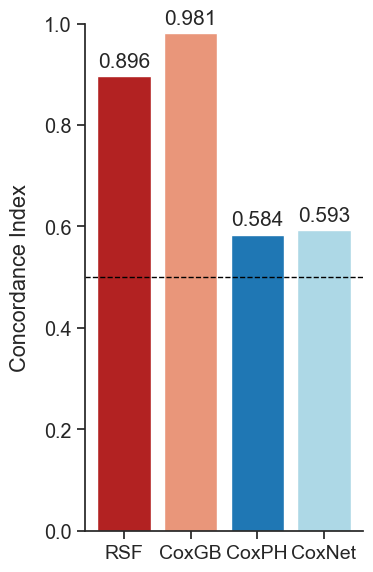

In [ ]:
sns.set(style="ticks", font_scale=1.3)

plt.figure(figsize=(4, 6))
methods = ["RSF", "CoxGB", "CoxPH", "CoxNet"]

# Use the means and stds from the 10-splits results
means = [rsf_cindex, gbsa_cindex, coxph_cindex, lasso_cindex]


colors = ["firebrick","darksalmon","tab:blue","lightblue"]

bars = plt.bar(
    methods, means, capsize=4,
    color=colors, edgecolor=None
)

for bar, mean in zip(bars, means):
    top = mean 
    plt.text(
        bar.get_x() + bar.get_width() / 2, top + 0.01,  # position slightly above error bar
        f"{mean:.3f}", ha='center', va='bottom', fontsize=15
    )
plt.ylabel("Concordance Index", labelpad=10)
plt.xticks(rotation=0, fontsize=14)
plt.ylim(0., 1.0)  # Adjust as needed based on your c-index range
plt.axhline(0.5, color='black', linestyle='--', linewidth=1, label='Random Guessing')
plt.tight_layout()
sns.despine()
plt.savefig('../figures/plots/ML_CI_fullsample.pdf', dpi=300)
plt.show()

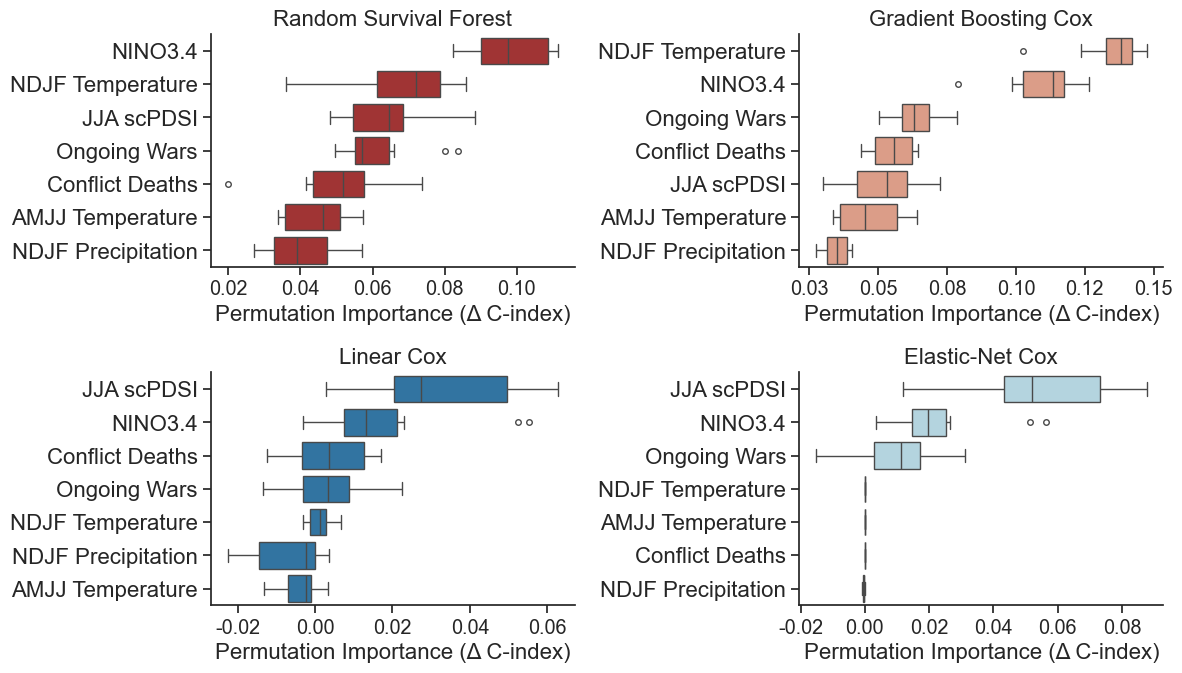

In [ ]:
cols_to_plot = {
    "avg_nino34": "NINO3.4",
    "avg_temp_summer": "AMJJ Temperature",
    "avg_temp_winter": "NDJF Temperature",
    "avg_precip_winter": "NDJF Precipitation",
    "avg_PDSI": "JJA scPDSI",
    "avg_ongoing_wars": "Ongoing Wars",
    "avg_Deaths": "Conflict Deaths"
}

perm_data = {
    "RSF": pd.DataFrame(perm_rsf.importances.T, columns=cols_renamed.values()),
    "GBSA": pd.DataFrame(perm_gbsa.importances.T, columns=cols_renamed.values()),
    "CoxPH": pd.DataFrame(perm_coxph.importances.T, columns=cols_renamed.values()),
    "LassoCox": pd.DataFrame(perm_lasso.importances.T, columns=cols_renamed.values())
}

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharey=False)
axes = axes.flatten()
colors = ["firebrick", "darksalmon", "tab:blue", "lightblue"]
titles = ["Random Survival Forest", "Gradient Boosting Cox", "Linear Cox", "Elastic-Net Cox"]

for i, (model_name, df) in enumerate(perm_data.items()):
    # Sort columns by median importance
    medians = df.median().sort_values(ascending=False)  # ascending=True for horizontal plot
    df_sorted = df[medians.index]
    
    sns.boxplot(data=df_sorted, orient="h", ax=axes[i], color=colors[i], fliersize=4)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel("Permutation Importance (Δ C-index)", fontsize=16)
    axes[i].set_ylabel("")  # optional
    axes[i].tick_params(axis='y', labelsize=16)


#XTICKS ARE 2FLOAT
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

plt.tight_layout()
sns.despine()
plt.savefig('../figures/plots/ML_featimp_fullsample.pdf', dpi=300)
plt.show()


# Onset

In [ ]:
onset_data = pd.read_csv("../processed data/famine_region_data.csv")

#add decade and region dummies
#add decade from year
onset_data["Decade"] = (onset_data["Year"] // 10 * 10).astype(str)

features = [
  "nino34",
   "ongoing_wars",
   "Deaths",
    "Decade",
    "temp_summer",
    "temp_winter",
    "precip_summer",
    "precip_winter",
    "PDSI"
]

#select only central europe region
onset_data = onset_data[onset_data["Region"] == "Central Europe"]

X = onset_data[features]
y = onset_data["Famine_start"]

## CV

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_and_plot_feature_sets(X, y, famine, feature_combinations, save_prefix="MLOnset", save_suffixes=None):

    sns.set(style="ticks", font_scale=1.2)  
    """
    Runs GB classifier for multiple feature sets and produces:
    1. Famine count bar plots (Observed, Predicted, Counterfactual)
    2. Permutation importance boxplots
    3. In-sample vs CV accuracy skill bar plots
    """

    param_grid_gb = {
        "max_depth": [1, 3, 5, 10],
        "n_estimators": [3, 5, 10, 50],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3,0.4, 0.5],
        "subsample": [0.7, 0.9],
        "max_features": ['sqrt', 0.5],
        "min_samples_leaf": [2, 5],
      "min_samples_split": [5, 10],
    }


    for feature_set in feature_combinations:
        title_suffix = save_suffixes[feature_combinations.index(feature_set)] if save_suffixes else "Features"

        # ---- Model training with GridSearchCV ----
        clf = GradientBoostingClassifier(random_state=42)
        #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid = GridSearchCV(clf, param_grid_gb, cv=10, scoring="f1", n_jobs=-1)
        grid.fit(X[feature_set], y)
        best_model = grid.best_estimator_

        print(f"\n=== Best Model ({title_suffix}) ===")
        print("Params:", grid.best_params_)
        print("CV best score:", grid.best_score_)

        # ---- Predictions ----
        pred_class = best_model.predict(X[feature_set])

        # ---- Counterfactual: force nino vars = 0 during famine-start years ----
        X_cf = X[feature_set].copy()
        if any("nino" in f for f in feature_set):
            mask = (famine["Famine_start"].values == 1) & (famine["nino34"].values > 0)
            nino_cols = [c for c in feature_set if "nino" in c]
            X_cf.loc[mask, nino_cols] = 0

        pred_cf_class = best_model.predict(X_cf)

        # ---- Famine counts ----
        df_pred = pd.DataFrame({
            "Region": famine["Region"].values,
            "Year": famine["Year"].values,
            "Observed": y.values,
            "Predicted": pred_class,
            "Counterfactual": pred_cf_class
        })

        
        df_pred["Predicted"] = ((df_pred["Observed"] == 1) & (df_pred["Predicted"] == 1)).astype(int)

        # Counterfactual restricted to observed famine-start years
        df_pred["Counterfactual"] = ((famine["Famine_start"].values == 1) & 
                                     (df_pred["Counterfactual"] == 1)).astype(int)
        
        df_region = df_pred.groupby("Region")[["Observed", "Predicted", "Counterfactual"]].sum().reset_index()
        df_melted = df_region.melt(
            id_vars="Region",
            value_vars=["Observed", "Predicted", "Counterfactual"],
            var_name="Scenario", value_name="Famine count"
        )

        # ---- Plot famine counts ----
        counts = df_melted.groupby("Scenario")["Famine count"].sum().reindex(["Observed","Predicted","Counterfactual"])
        fig, ax = plt.subplots(figsize=(4,5))
        sns.barplot(
            x=counts.index, y=counts.values,
            palette={"Observed":"firebrick","Predicted":"darksalmon","Counterfactual":"cornflowerblue"},
            ax=ax
        )
        for i, v in enumerate(counts.values):
            ax.text(i, v + 0.05, int(v), ha='center', va='bottom', fontsize=15, fontweight="bold")
        ax.set_ylabel("Number of famines"); ax.set_xlabel(""); ax.set_yticks([])
        plt.ylim(0, max(counts.values)*1.2)
        sns.despine()
        plt.tight_layout()
        plt.savefig(f"../figures/plots/{save_prefix}_{title_suffix}_counts.pdf", dpi=300)
        plt.show()

        # ---- Accuracy skill ----
        in_sample_acc = accuracy_score(y, pred_class)
        cv_scores = cross_val_score(best_model, X[feature_set], y, cv=10, scoring="accuracy")
        oos_mean, oos_std = cv_scores.mean(), cv_scores.std()

        skill_df = pd.DataFrame({
            "Skill": ["In-sample", "Cross-Validation"],
            "Accuracy": [in_sample_acc, oos_mean],
            "CI": [0, oos_std]
        })

        fig, ax = plt.subplots(figsize=(4,5))
        sns.barplot(data=skill_df, x="Skill", y="Accuracy",
                    palette={"In-sample":"firebrick","Cross-Validation":"darksalmon"},
                    ax=ax, capsize=0.2)
        for i, row in skill_df.iterrows():
            if row.Skill == "Cross-Validation":
                ax.errorbar(i, row.Accuracy, yerr=row.CI, color='black', fmt='none', capsize=2, elinewidth=2)
        ax.set_ylim(0,1); ax.set_xlabel("")
        plt.tight_layout()
        sns.despine()
        plt.savefig(f"../figures/plots/{save_prefix}_{title_suffix}_skill.pdf", dpi=300)
        plt.show()



=== Best Model (NINO34) ===
Params: {'learning_rate': 0.4, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 3, 'subsample': 0.9}
CV best score: 0.16666666666666666


C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


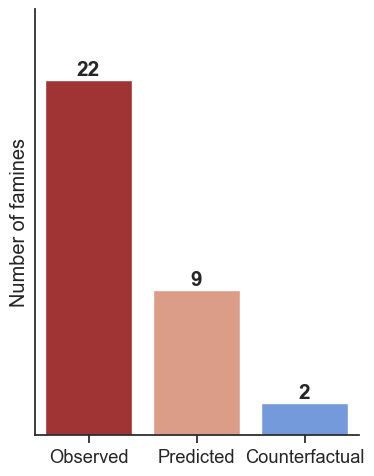

C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, x="Skill", y="Accuracy",


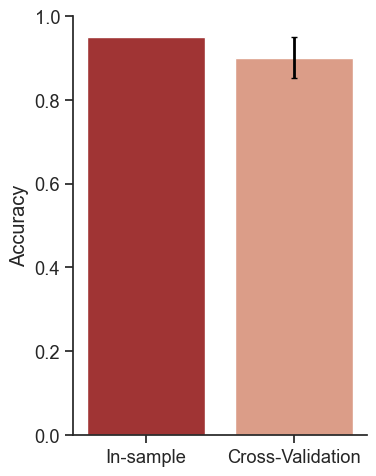


=== Best Model (NINO_conflict) ===
Params: {'learning_rate': 0.4, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 3, 'subsample': 0.9}
CV best score: 0.14444444444444443


C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


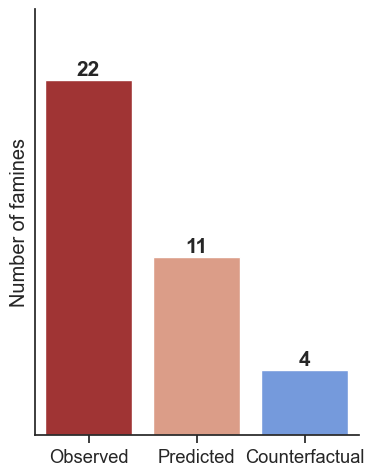

C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, x="Skill", y="Accuracy",


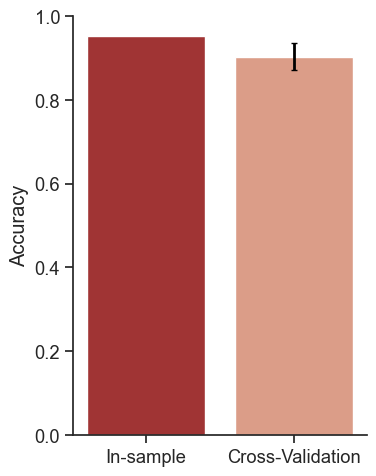


=== Best Model (Nino_conflict_temp) ===
Params: {'learning_rate': 0.5, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 3, 'subsample': 0.7}
CV best score: 0.15666666666666668


C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


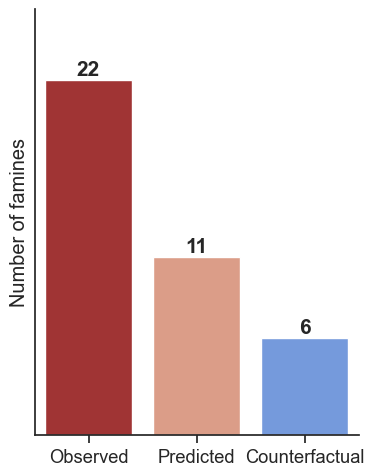

C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, x="Skill", y="Accuracy",


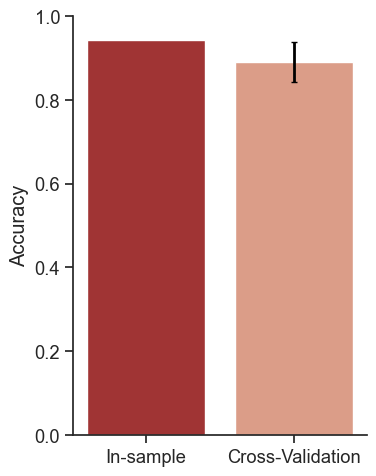


=== Best Model (nino_conflict_precip) ===
Params: {'learning_rate': 0.3, 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5, 'subsample': 0.7}
CV best score: 0.1852380952380952


C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


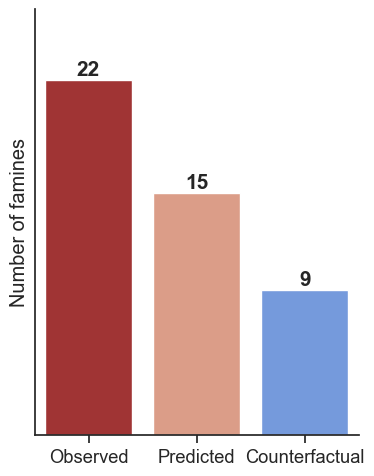

C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, x="Skill", y="Accuracy",


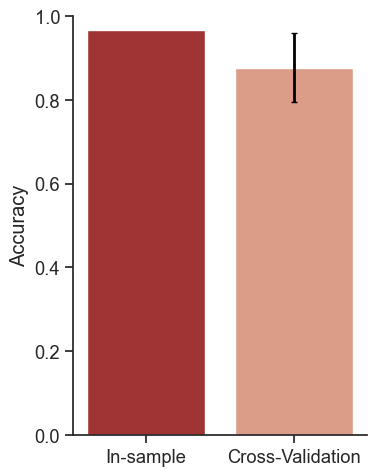


=== Best Model (All_features) ===
Params: {'learning_rate': 0.5, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10, 'subsample': 0.7}
CV best score: 0.17333333333333334


C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


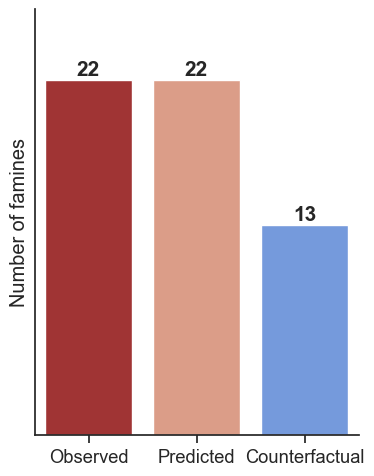

C:\Users\emile\AppData\Local\Temp\ipykernel_26296\2521370422.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, x="Skill", y="Accuracy",


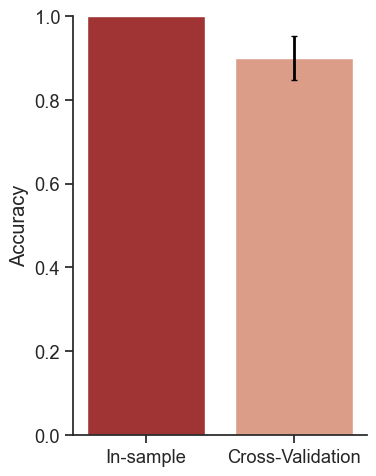

In [158]:
feature_combinations = [
    ["nino34"],
    ["nino34", "ongoing_wars", "Deaths"],
    ["nino34", "ongoing_wars", "Deaths", "temp_winter", "temp_summer"],
    ["nino34", "ongoing_wars", "Deaths", "temp_winter", "temp_summer", "precip_winter","precip_summer"],
    ["nino34", "ongoing_wars", "Deaths", "temp_winter", "temp_summer", "PDSI", "precip_winter"]

]

save_suffixes = [
    "NINO34",
    "NINO_conflict",
    "Nino_conflict_temp",
    "nino_conflict_precip",
    "All_features"
]



run_and_plot_feature_sets(X, y, onset_data, feature_combinations, save_suffixes=save_suffixes)

# Plot CF2

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator

# --- Classic theme setup ---
sns.set_style("ticks")
plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.color": "black",
    "ytick.color": "black",
})


def apply_classic_style(ax, xaxis=True, yaxis=True):
    """Apply theme_classic-like style with mini ticks to an axis."""
    # Hide top/right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_linewidth(1.2)

    # Major ticks
    ax.tick_params(axis='x', which='major', length=6, width=1.2, direction='out', labelsize=12)
    ax.tick_params(axis='y', which='major', length=6, width=1.2, direction='out', labelsize=12)
    

    # Tick label weight
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontweight("normal")

    if not xaxis:
        ax.set_xticks([])
    if not yaxis:
        ax.set_yticks([])


def run_and_plot_feature_sets(X, y, famine, feature_combinations, save_prefix="MLOnset", save_suffixes=None):
    param_grid_gb = {
        "max_depth": [1, 3, 5, 10],
        "n_estimators": [3, 5, 10, 50],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        "subsample": [0.7, 0.9],
        "max_features": ['sqrt', 0.5],
        "min_samples_leaf": [2, 5],
        "min_samples_split": [5, 10],
    }

    for feature_set in feature_combinations:
        title_suffix = save_suffixes[feature_combinations.index(feature_set)] if save_suffixes else "Features"

        # ---- Model training ----
        clf = GradientBoostingClassifier(random_state=42)
        grid = GridSearchCV(clf, param_grid_gb, cv=10, scoring="f1", n_jobs=-1)
        grid.fit(X[feature_set], y)
        best_model = grid.best_estimator_

        print(f"\n=== Best Model ({title_suffix}) ===")
        print("Params:", grid.best_params_)
        print("CV best score:", grid.best_score_)

        # ---- Predictions ----
        pred_class = best_model.predict(X[feature_set])

        # Counterfactual
        X_cf = X[feature_set].copy()
        if any("nino" in f for f in feature_set):
            mask = (famine["Famine_start"].values == 1) & (famine["nino34"].values > 0)
            nino_cols = [c for c in feature_set if "nino" in c]
            X_cf.loc[mask, nino_cols] = 0
        pred_cf_class = best_model.predict(X_cf)

        # ---- Chronology DataFrame ----
        df_chronology = pd.DataFrame({
            "Region": famine["Region"].values,
            "Year": famine["Year"].values,
            "Observed": y.values,
            "Predicted": pred_class,
            "Counterfactual": pred_cf_class,
            "NINO34_actual": famine["nino34"].values if "nino34" in famine.columns else np.zeros(len(famine)),
            "NINO34_counterfactual": X_cf["nino34"].values if "nino34" in feature_set else np.zeros(len(X_cf))
        })
        df_chronology["Predicted"] = ((df_chronology["Observed"] == 1) & (df_chronology["Predicted"] == 1)).astype(int)
        df_chronology["Counterfactual"] = ((famine["Famine_start"].values == 1) &
                                            (df_chronology["Counterfactual"] == 1)).astype(int)

        # ---- Chronology plot ----
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), height_ratios=[1, 1])
        regions = sorted(df_chronology["Region"].unique())
        years = sorted(df_chronology["Year"].unique())
        year_min, year_max = min(years), max(years)
        colors = {"Observed": "firebrick", "Predicted": "darksalmon", "Counterfactual": "cornflowerblue"}
        famine_counts = {r: {s: df_chronology[df_chronology["Region"]==r][s].sum()
                             for s in ["Observed","Predicted","Counterfactual"]} for r in regions}

        y_positions = {}
        for i, region in enumerate(regions):
            base_y = i * 6
            y_positions[region] = {"Observed": base_y + 3, "Predicted": base_y + 1.5, "Counterfactual": base_y}
            region_data = df_chronology[df_chronology["Region"] == region].sort_values("Year")
            for scenario in ["Observed", "Predicted", "Counterfactual"]:
                onset_mask = region_data[scenario] == 1
                onset_years = region_data.loc[onset_mask, "Year"].values
                onset_idx = region_data.loc[onset_mask].index
                for year, idx in zip(onset_years, onset_idx):
                    dur = famine.iloc[idx]["Famine_dur"] if "Famine_dur" in famine.columns else 1
                    ax1.barh(y=y_positions[region][scenario], width=dur, left=year, height=1.2,
                             color=colors[scenario], edgecolor="black", linewidth=2, alpha=0.7)

        y_ticks, y_labels = [], []
        for i, region in enumerate(regions):
            for scenario in ["Counterfactual", "Predicted", "Observed"]:
                y_ticks.append(y_positions[region][scenario])
                count = famine_counts[region][scenario]
                y_labels.append(f"{scenario} ({count})")
        ax1.set_yticks(y_ticks)
        ax1.set_xlim(year_min - 1, year_max + 1)
        apply_classic_style(ax1)
        ax1.set_yticklabels(y_labels, fontsize=13)
        ax1.tick_params(axis='x', labelsize=13)
        ax1.set_xlabel("Year", fontsize=13)

        # ---- NINO34 bottom panel ----
        nino_actual = df_chronology.groupby("Year")["NINO34_actual"].first().reindex(years, fill_value=0).values
        nino_cf = df_chronology.groupby("Year")["NINO34_counterfactual"].first().reindex(years, fill_value=0).values
        ax2.plot(years, nino_actual, color="crimson", linewidth=1.2, label="Observed", alpha=0.8)
        ax2.plot(years, nino_cf, color="dodgerblue", linewidth=1.5, linestyle="solid", label="Counterfactual", alpha=1)
        diff_mask = (nino_actual != nino_cf) & (nino_actual >= 0.5)
        ax2.scatter(np.array(years)[diff_mask], np.array(nino_actual)[diff_mask],
                    color="red", s=25, zorder=5, label="> 0.5°C")
        ax2.axhline(0, color="black", linestyle="-", alpha=0.3)
        ax2.axhline(0.5, color="black", linestyle="--", alpha=0.5)
        ax2.set_xlim(year_min - 1, year_max + 1)
        apply_classic_style(ax2)
        ax2.set_xlabel("Year", fontsize=13)
        ax2.set_ylabel("NINO3.4", fontsize=13)
        ax2.legend(loc="lower left", prop={"weight": "normal", "size": 11})
        ax2.tick_params(axis='x', labelsize=13)
        


        plt.tight_layout()
        plt.savefig(f"../figures/plots/{save_prefix}_{title_suffix}_chronology.pdf", dpi=300, bbox_inches="tight")
        plt.show()

        # ---- Permutation importances ----
        perm_importance = permutation_importance(best_model, X[feature_set], y, n_repeats=50,
                                                 random_state=42, scoring="f1", n_jobs=-1)
        df_list = [pd.DataFrame({"Feature": feature, "Importance": perm_importance['importances'][i]})
                   for i, feature in enumerate(feature_set)]
        df_importances = pd.concat(df_list, axis=0)
        df_importances["Feature"] = df_importances["Feature"].replace({
            "nino34": "NINO3.4",
            "ongoing_wars": "Ongoing Wars",
            "Deaths": "Conflict Deaths",
            "temp_winter": "NDJF Temp",
            "temp_summer": "AMJJ Temp",
            "precip_winter": "NDJF Precip",
            "PDSI": "JJA scPDSI",
            "precip_summer": "AMJJ Precip"
        })
        median_order = df_importances.groupby("Feature")["Importance"].median().sort_values(ascending=False).index

        fig, ax = plt.subplots(figsize=(6,4))
        sns.boxplot(x="Importance", y="Feature", data=df_importances, order=median_order, palette="Reds_r", ax=ax)
        plt.xlabel("Permutation Importance", fontsize=16)
        plt.ylabel("")
        apply_classic_style(ax)
        # Set tick label sizes reliably
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        #format x ticks to be 0.2f format
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
        plt.tight_layout()
        plt.savefig(f"../figures/plots/{save_prefix}_{title_suffix}_importances.pdf", dpi=300)
        plt.show()

        # ---- Accuracy skill ----
        in_sample_acc = accuracy_score(y, pred_class)
        cv_scores = cross_val_score(best_model, X[feature_set], y, cv=10, scoring="accuracy")
        oos_mean, oos_std = cv_scores.mean(), cv_scores.std()
        skill_df = pd.DataFrame({
            "Skill": ["In-sample", "Cross-Validation"],
            "Accuracy": [in_sample_acc, oos_mean],
            "CI": [0, oos_std]
        })
        fig, ax = plt.subplots(figsize=(6,2))
        sns.barplot(data=skill_df, y="Skill", x="Accuracy",
                    palette={"In-sample":"firebrick","Cross-Validation":"darksalmon"},
                    ax=ax, capsize=0)
        for i, row in skill_df.iterrows():
            if row.Skill == "Cross-Validation":
                ax.errorbar(x=row.Accuracy, y=i, xerr=row.CI, color='black', fmt='none', capsize=4, elinewidth=2)
        ax.set_xlim(0,1)
        ax.set_xlabel("Accuracy", fontsize=16)
        ax.set_yticklabels(["In-sample", "Cross-Validation"])  
        apply_classic_style(ax)
        plt.setp(ax.get_yticklabels(), fontsize=16)  # <-- this works reliably with Seaborn
        #set ticks size
        ax.tick_params(axis='x', labelsize=14)

        plt.tight_layout()
        plt.savefig(f"../figures/plots/{save_prefix}_{title_suffix}_skillHor.pdf", dpi=300)
        plt.show()



=== Best Model (NINO34) ===
Params: {'learning_rate': 0.4, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 3, 'subsample': 0.9}
CV best score: 0.16666666666666666


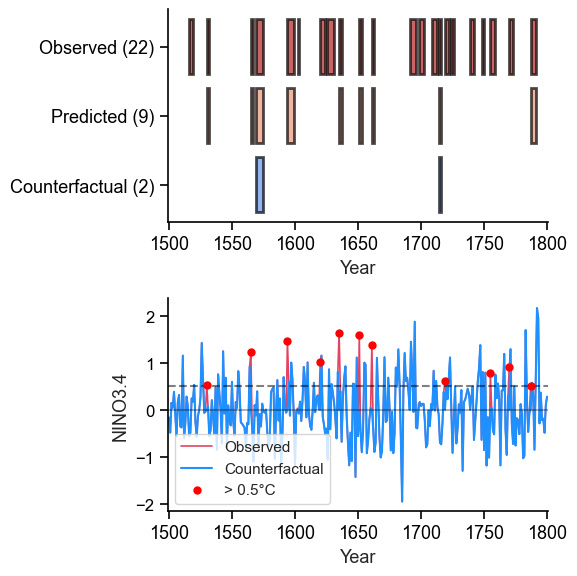

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Importance", y="Feature", data=df_importances, order=median_order, palette="Reds_r", ax=ax)


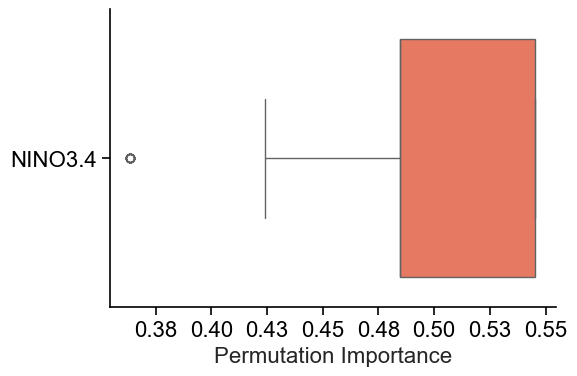

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, y="Skill", x="Accuracy",
C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["In-sample", "Cross-Validation"])


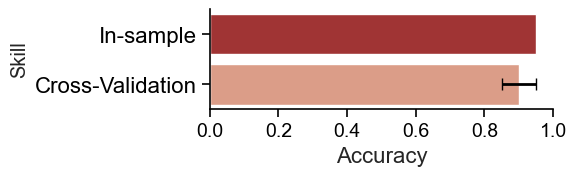


=== Best Model (NINO_conflict) ===
Params: {'learning_rate': 0.4, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 3, 'subsample': 0.9}
CV best score: 0.14444444444444443


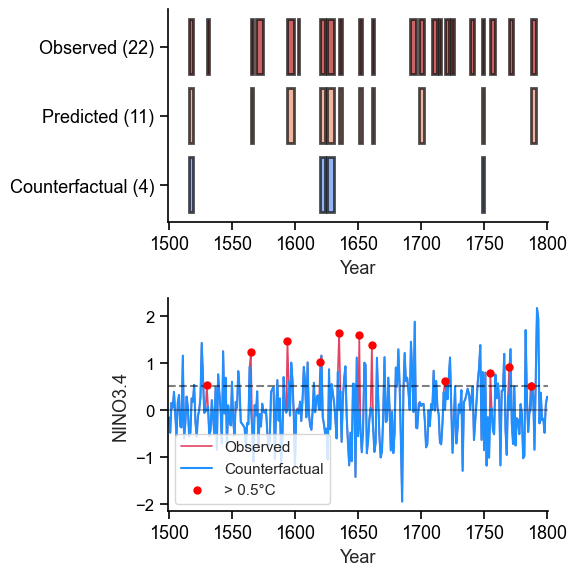

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Importance", y="Feature", data=df_importances, order=median_order, palette="Reds_r", ax=ax)


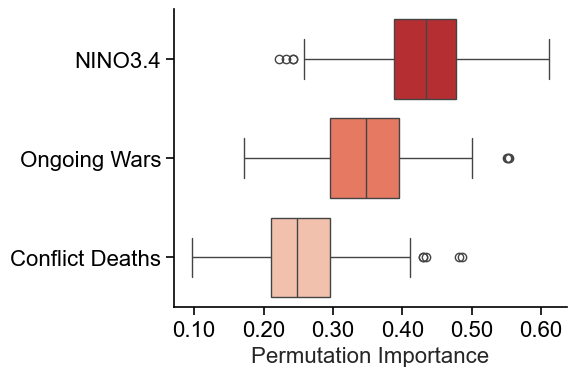

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, y="Skill", x="Accuracy",
C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["In-sample", "Cross-Validation"])


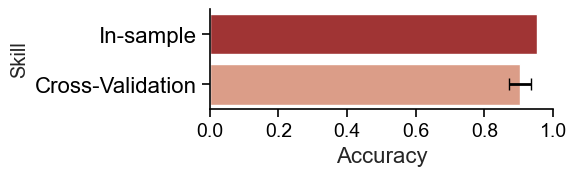


=== Best Model (Nino_conflict_temp) ===
Params: {'learning_rate': 0.5, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 3, 'subsample': 0.7}
CV best score: 0.15666666666666668


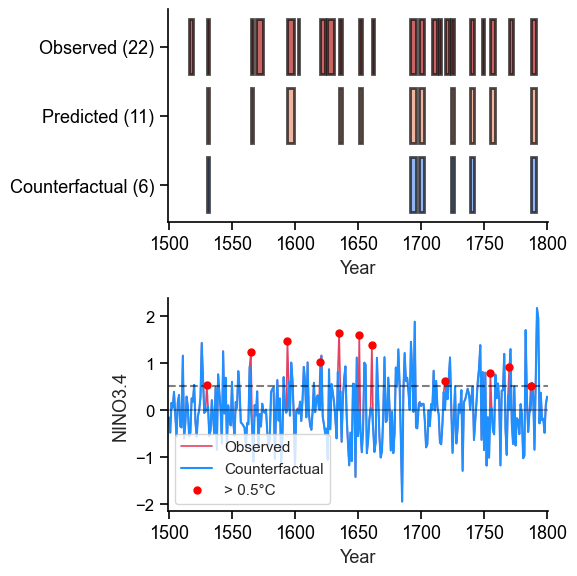

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Importance", y="Feature", data=df_importances, order=median_order, palette="Reds_r", ax=ax)


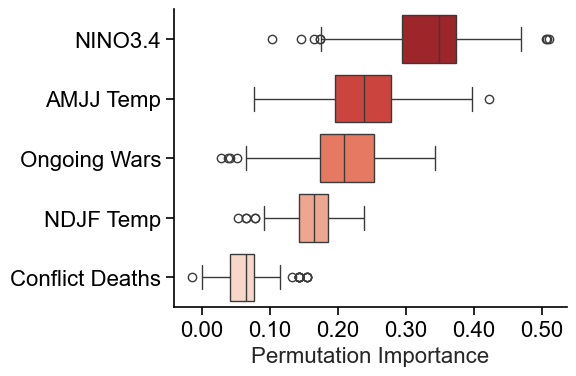

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, y="Skill", x="Accuracy",
C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["In-sample", "Cross-Validation"])


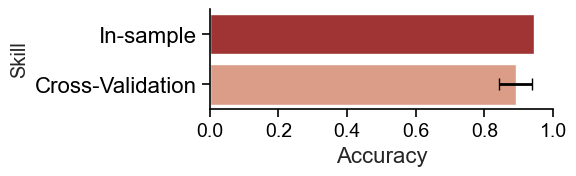


=== Best Model (nino_conflict_precip) ===
Params: {'learning_rate': 0.3, 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5, 'subsample': 0.7}
CV best score: 0.1852380952380952


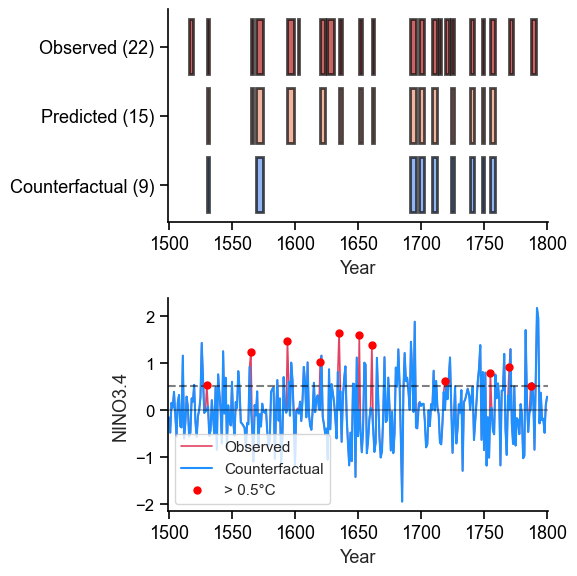

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Importance", y="Feature", data=df_importances, order=median_order, palette="Reds_r", ax=ax)


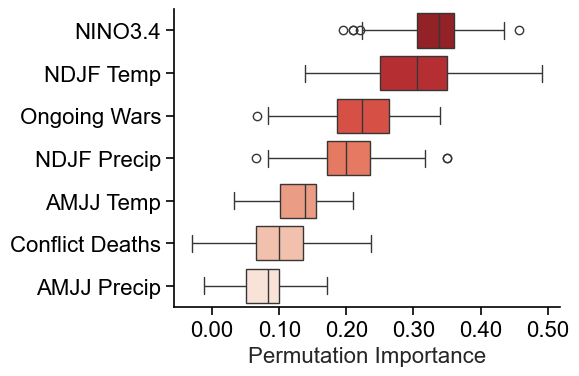

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, y="Skill", x="Accuracy",
C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["In-sample", "Cross-Validation"])


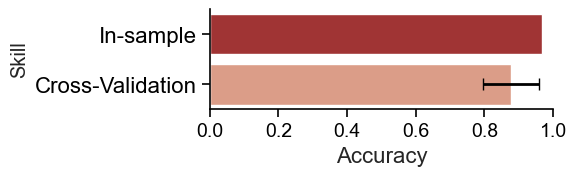


=== Best Model (All_features) ===
Params: {'learning_rate': 0.5, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10, 'subsample': 0.7}
CV best score: 0.17333333333333334


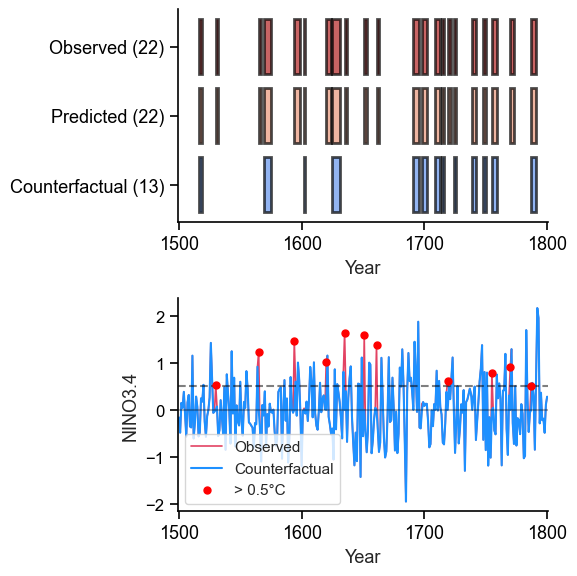

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Importance", y="Feature", data=df_importances, order=median_order, palette="Reds_r", ax=ax)


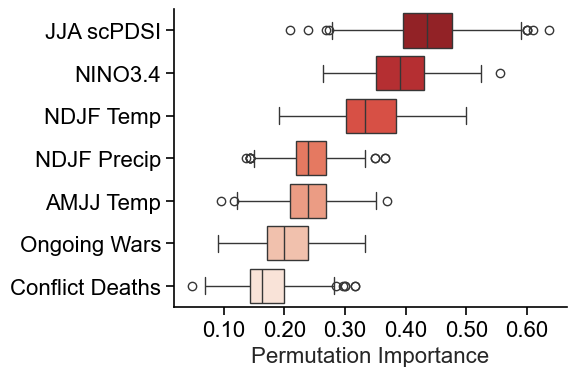

C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skill_df, y="Skill", x="Accuracy",
C:\Users\emile\AppData\Local\Temp\ipykernel_15708\953028760.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["In-sample", "Cross-Validation"])


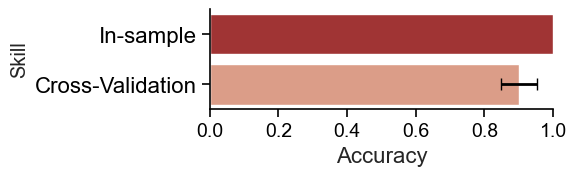

In [23]:
feature_combinations = [
    ["nino34"],
    ["nino34", "ongoing_wars", "Deaths"],
    ["nino34", "ongoing_wars", "Deaths", "temp_winter", "temp_summer"],
    ["nino34", "ongoing_wars", "Deaths", "temp_winter", "temp_summer", "precip_winter","precip_summer"],
    ["nino34", "ongoing_wars", "Deaths", "temp_winter", "temp_summer", "PDSI", "precip_winter"]

]

save_suffixes = [
    "NINO34",
    "NINO_conflict",
    "Nino_conflict_temp",
    "nino_conflict_precip",
    "All_features"
]



run_and_plot_feature_sets(X, y, onset_data, feature_combinations, save_suffixes=save_suffixes)